In [110]:
%matplotlib inline
from IPython.display import display

import matplotlib.pyplot as plt
import numpy
import pandas
import pickle
import os
import re

from sklearn import metrics

In [111]:
import seaborn
seaborn.set_style('white')
seaborn.set_palette('colorblind')

In [10]:
METRICS_COLS = ['AUC', 'RMSE', 'Accuracy', 'R2']

In [11]:
def get_runs(dirname):
    return [run_prediction for run_prediction in os.listdir(dirname)
            if os.path.isfile(os.path.join(dirname, run_prediction)) and 'prediction' in run_prediction]

def get_learning(dirname):
    return [run_prediction for run_prediction in os.listdir(dirname)
            if os.path.isfile(os.path.join(dirname, run_prediction)) and 'performance' in run_prediction]

In [12]:
def read_predictions(filename):
    with open(filename, 'rb') as prediction_file:
        return pickle.load(prediction_file)

def get_metrics_list(true, predicted):
    try:
        auc = metrics.roc_auc_score(true, predicted)
    except ValueError:
        auc = numpy.nan
    rmse = metrics.mean_squared_error(true, predicted)**0.5
    accuracy = metrics.accuracy_score(true, numpy.where(predicted > 0.5, 1, 0))
    r2 = metrics.r2_score(true, predicted)
    support = true.shape[0]
    return [auc, rmse, accuracy, r2, support]

def read_file_metrics(predictions_df):
    """Returns a DataFrame with values AUC, RMSE, APS, Accuracy, R2 Score"""
    metrics_list = []
    grouped = predictions_df.groupby(['run', 'period'])
    for (run, period), df in grouped:
        true, predicted = df.true.values, df.predicted.values
        metrics_list.append(get_metrics_list(true, predicted) + [run, period])
    return pandas.DataFrame(metrics_list, columns=METRICS_COLS + ['Support', 'Run', 'Period'])

In [14]:
def read_metrics(dirnames):
    metrics_dfs = []
    for dirname in dirnames:
        all_predictions = []
        for filename in get_runs(dirname):
            predictions_df = read_predictions(os.path.join(dirname, filename))
            all_predictions.append(predictions_df)
            file_metrics = read_file_metrics(predictions_df)
            file_metrics['Experiment'] = dirname[-16:]
            course = re.search('.*_c(\d+).*', filename)
            if course is not None:
                file_metrics['Course'] = int(re.search('.*_c(\d+).*', filename).group(1))
            else:
                file_metrics['Course'] = 1
            metrics_dfs.append(file_metrics)
        general_metrics = read_file_metrics(pandas.concat(all_predictions))
        general_metrics['Experiment'] = dirname[-16:]
        general_metrics['Course'] = -1
        metrics_dfs.append(general_metrics)
    return pandas.concat(metrics_dfs, ignore_index=True)

In [66]:
def read_performances(dirnames):
    results = {}
    for dirname in reversed(dirnames):
        dataframes = []
        for filename in get_learning(dirname):
            with open(os.path.join(dirname, filename), 'rb') as performance_file:
                performance_df = pickle.load(performance_file)
            course = re.search('.*_c(\d+).*', filename)
            if course is not None:
                performance_df['Course'] = int(course.group(1))
            else:
                performance_df['Course'] = 1
            performance_df['rmse'] = performance_df['mse']**0.5
            dataframes.append(performance_df)
        if len(dataframes) > 0:
            results[dirname] = pandas.concat(dataframes)
    return results

def graphic_performances(train_performances):
    performances = []
    for dirname, performance_dataframe in train_performances.items():
        perf = performance_dataframe.groupby(['epoch', 'run', 'Course']).agg({'rmse': 'std'}).groupby(
            'Course').agg('mean')
        perf['Experiment'] = dirname[-16:]
        performances.append(perf.reset_index())
    performances = pandas.concat(performances, ignore_index=True)
    seaborn.factorplot(x='Course', y='rmse', col="Experiment", data=performances, col_wrap=4)

def graphic_learning_curves(train_performances):
    for dirname, performance_dataframe in train_performances.items():
        print(dirname)
        performance_dataframe['epoch'] = performance_dataframe.epoch.astype(numpy.int)
        grid = seaborn.FacetGrid(data=performance_dataframe.loc[performance_dataframe['run'] == 0],
                                 col='Course', despine=True, ylim=[0, 0.5], aspect=1,
                                 palette='colorblind')
        mapped = grid.map(seaborn.pointplot, 'epoch', 'rmse', 'dataset').add_legend().set_xticklabels([])
        plt.show()

## Experiments with LSTM

In [15]:
LSTM_EXPERIMENTS_DIRS = [
    '/home/mteruel/edm/results/kdd_early_dropout/lstm/predictions/18-01-17-09-41/',
]

In [16]:
lstm_metrics = read_metrics(LSTM_EXPERIMENTS_DIRS)

In [17]:
lstm_metrics

,AUC,RMSE,Accuracy,R2,Support,Run,Period,Experiment,Course
0,0.766332,0.445958,0.722838,0.204069,1353,0,0,/18-01-17-09-41/,1
1,0.822783,0.411183,0.765060,0.309681,1992,0,1,/18-01-17-09-41/,1
2,0.836929,0.382065,0.798971,0.351766,2333,0,2,/18-01-17-09-41/,1
3,0.882055,0.341217,0.849283,0.464967,2581,0,3,/18-01-17-09-41/,1
4,0.761221,0.445216,0.713230,0.206714,1353,1,0,/18-01-17-09-41/,1
5,0.824967,0.405304,0.771084,0.329280,1992,1,1,/18-01-17-09-41/,1
6,0.840787,0.380214,0.801114,0.358031,2333,1,2,/18-01-17-09-41/,1
7,0.880484,0.340009,0.850058,0.468750,2581,1,3,/18-01-17-09-41/,1
8,0.750374,0.424450,0.753213,0.183978,389,0,0,/18-01-17-09-41/,11
9,0.809149,0.327684,0.851301,0.279230,538,0,1,/18-01-17-09-41/,11


In [38]:
lstm_metrics[lstm_metrics.Course == -1].groupby(['Experiment', 'Period']).mean()[METRICS_COLS]

AUC      RMSE  Accuracy        R2
Experiment       Period                                        
/18-01-17-09-41/ 0       0.765980  0.436772  0.737137  0.199973
                 1       0.823425  0.384549  0.800958  0.312414
                 2       0.818788  0.354103  0.833846  0.305601
                 3       0.844894  0.329225  0.860746  0.382175

In [37]:
lstm_metrics.groupby(['Experiment', 'Course']).mean()[METRICS_COLS]

AUC      RMSE  Accuracy        R2
Experiment       Course                                        
/18-01-17-09-41/ -1      0.813272  0.376162  0.808172  0.300041
                  1      0.826945  0.393896  0.783955  0.336657
                  6      0.797096  0.346649  0.836492  0.275882
                  11     0.765478  0.347490  0.834362  0.195548
                  16     0.759795  0.406219  0.783207  0.170342
                  21     0.709376  0.383247  0.809647  0.033128
                  26     0.638567  0.325671  0.872714  0.051056
                  31     0.786288  0.379830  0.808209  0.139386

### Overfitting analysis

In [68]:
lstm_performances = read_performances(LSTM_EXPERIMENTS_DIRS)

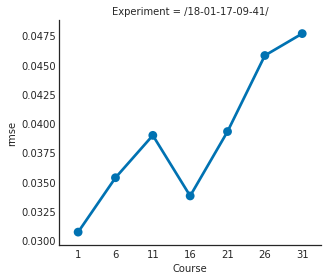

In [69]:
graphic_performances(lstm_performances)

/home/mteruel/edm/results/kdd_early_dropout/lstm/predictions/18-01-17-09-41/


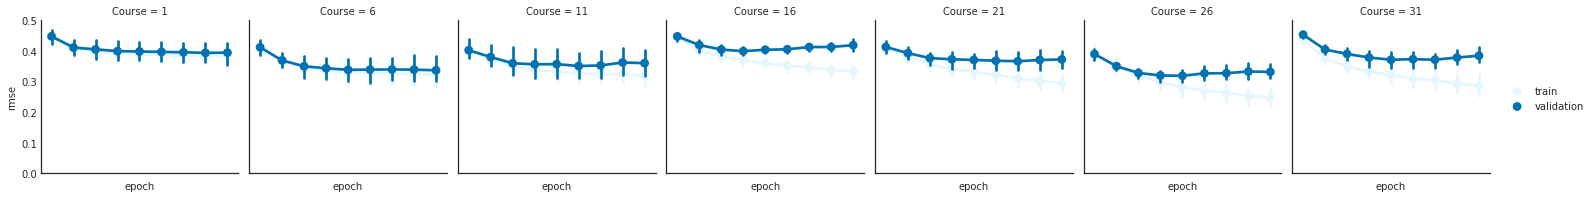

In [70]:
graphic_learning_curves(lstm_performances)

### Performance on all periods, aggregated by course

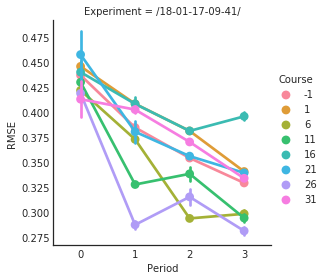

In [11]:
seaborn.factorplot(x='Period', y='RMSE', hue='Course', col="Experiment", data=lstm_metrics)

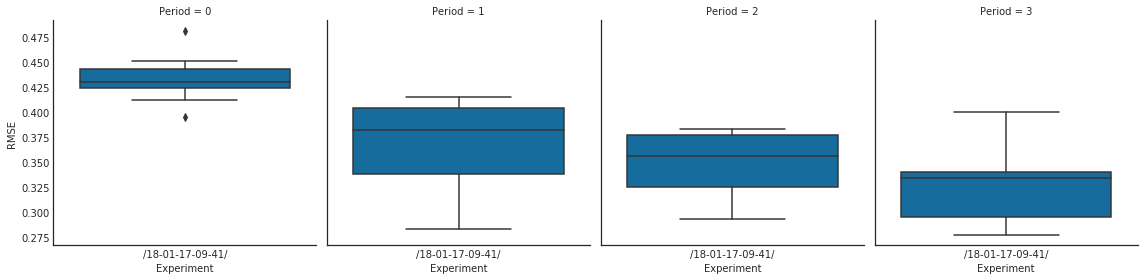

In [130]:
seaborn.factorplot(x='Experiment', y='RMSE', col="Period",
                   data=lstm_metrics[lstm_metrics.Course > 0], kind='box')

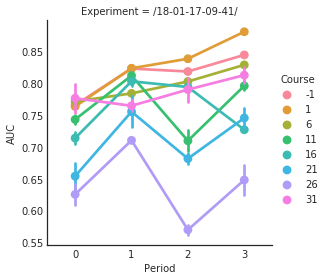

In [23]:
seaborn.factorplot(x='Period', y='AUC', hue='Course', col="Experiment", data=lstm_metrics)

### Performance on all courses, aggregated by period

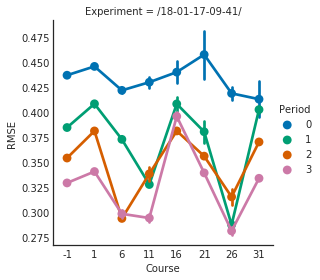

In [93]:
seaborn.factorplot(x='Course', y='RMSE', hue='Period', col="Experiment", data=lstm_metrics)

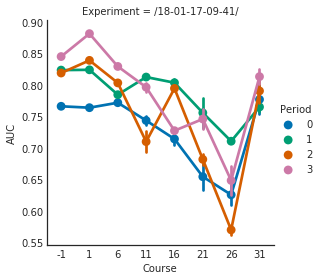

In [24]:
seaborn.factorplot(x='Course', y='AUC', hue='Period', col="Experiment", data=lstm_metrics)

# Experiments with embeddings

In [131]:
EMBEDDED_EXPERIMENTS_DIRS = [
    '/home/mteruel/edm/results/kdd_early_dropout/embedded/predictions/18-01-17-12-48/',
    '/home/mteruel/edm/results/kdd_early_dropout/embedded/predictions/18-01-17-19-14/',
    '/home/mteruel/edm/results/kdd_early_dropout/embedded/predictions/18-01-18-11-28/',
]

In [132]:
embedded_metrics = read_metrics(EMBEDDED_EXPERIMENTS_DIRS)

In [133]:
embedded_metrics[embedded_metrics.Course == -1].groupby(
    ['Experiment', 'Period']).mean()[['AUC', 'RMSE']]

AUC      RMSE
Experiment       Period                    
/18-01-17-12-48/ 0       0.768567  0.436731
                 1       0.825954  0.384683
                 2       0.833957  0.351823
                 3       0.859423  0.326341
/18-01-17-19-14/ 0       0.770457  0.434132
                 1       0.833787  0.381913
                 2       0.843070  0.348278
                 3       0.863570  0.323437
/18-01-18-11-28/ 0       0.767641  0.437750
                 1       0.828501  0.383220
                 2       0.835835  0.351295
                 3       0.860088  0.322880

In [134]:
embedded_metrics.groupby(['Experiment', 'Course']).mean()[METRICS_COLS]

AUC      RMSE  Accuracy        R2
Experiment       Course                                        
/18-01-17-12-48/ -1      0.821975  0.374894  0.803996  0.304873
                  1      0.829817  0.395784  0.775151  0.330120
                  6      0.803603  0.346791  0.836802  0.275194
                  11     0.775443  0.348147  0.831954  0.191683
                  16     0.787469  0.399275  0.781436  0.198745
                  21     0.755273  0.369692  0.816555  0.099105
                  26     0.716293  0.321589  0.861900  0.079902
                  31     0.806722  0.374581  0.806491  0.166777
/18-01-17-19-14/ -1      0.827721  0.371940  0.809610  0.315839
                  1      0.835905  0.390755  0.783933  0.347012
                  6      0.812451  0.345597  0.837202  0.279329
                  11     0.791693  0.340869  0.840230  0.228252
                  16     0.790205  0.394377  0.789754  0.218254
                  21     0.746232  0.369354  0.820622  0.102705
                  26     0.711714  0.328659  0.862738  0.045973
                  31     0.791582  0.381727  0.801340  0.131005
/18-01-18-11-28/ -1      0.823016  0.373786  0.808114  0.308952
                  1      0.838852  0.390579  0.783555  0.347765
                  6      0.810085  0.343932  0.835975  0.288233
                  11     0.783240  0.341916  0.839575  0.225889
                  16     0.780056  0.399106  0.780611  0.200299
                  21     0.735063  0.377166  0.816893  0.062060
                  26     0.699355  0.334500  0.859378  0.005777
                  31     0.738813  0.399881  0.805436  0.045340

### Overfitting analysis

In [135]:
embedded_performances = read_performances(EMBEDDED_EXPERIMENTS_DIRS)

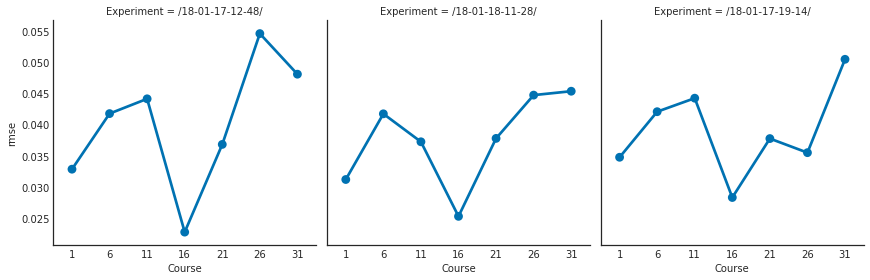

In [136]:
graphic_performances(embedded_performances)

/home/mteruel/edm/results/kdd_early_dropout/embedded/predictions/18-01-17-12-48/


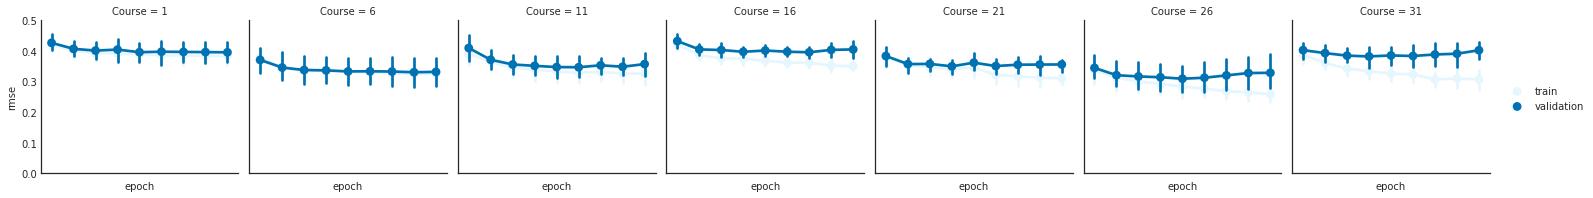

/home/mteruel/edm/results/kdd_early_dropout/embedded/predictions/18-01-18-11-28/


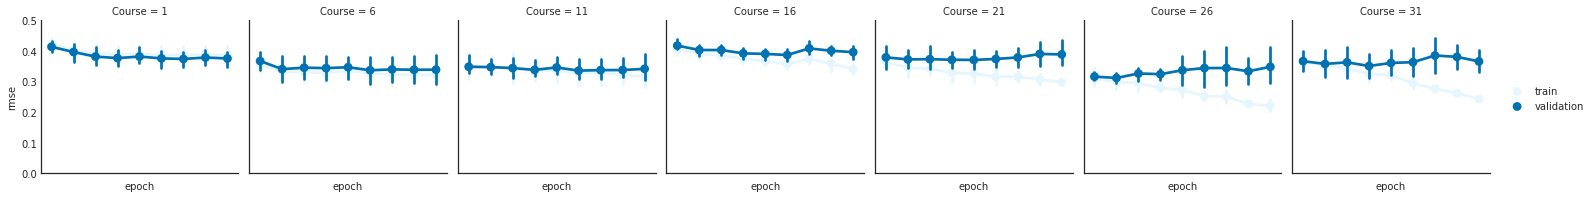

/home/mteruel/edm/results/kdd_early_dropout/embedded/predictions/18-01-17-19-14/


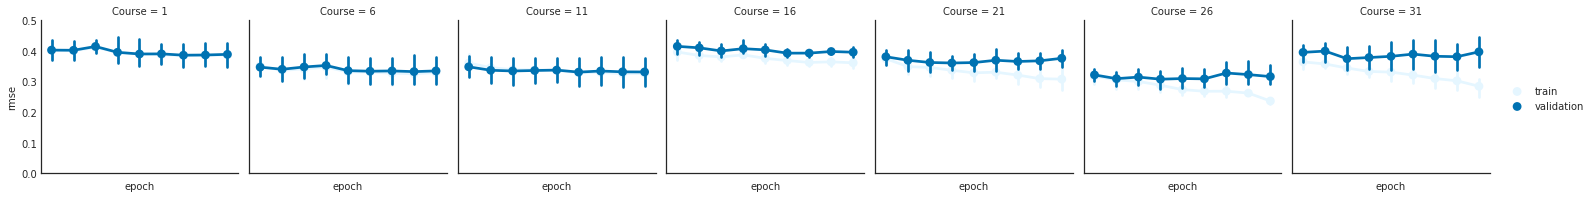

In [137]:
graphic_learning_curves(embedded_performances)

### Performance on all periods, aggregated by course

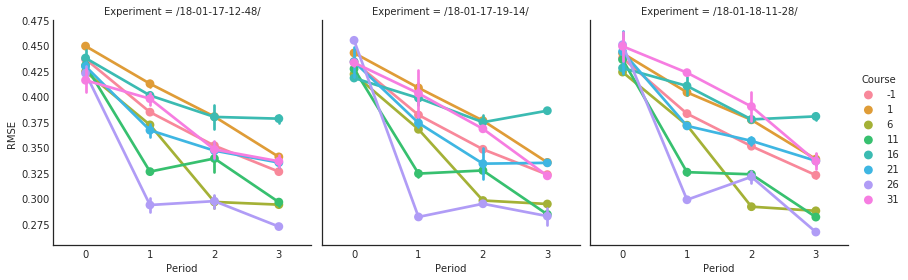

In [138]:
seaborn.factorplot(x='Period', y='RMSE', hue='Course', col="Experiment", data=embedded_metrics)

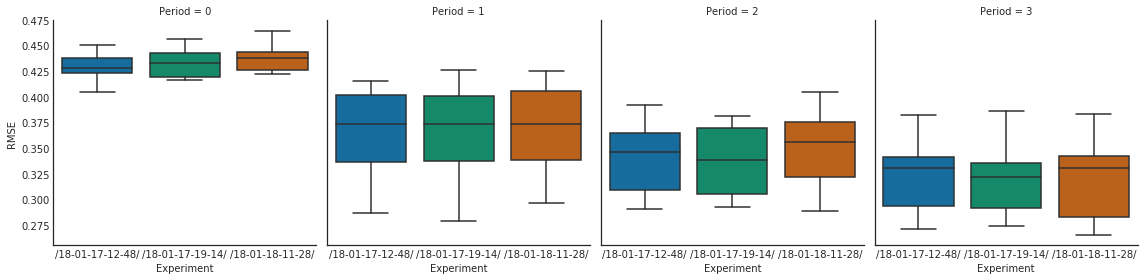

In [140]:
seaborn.factorplot(x='Experiment', y='RMSE', col="Period",
                   data=embedded_metrics[embedded_metrics.Course > 0], kind='box')

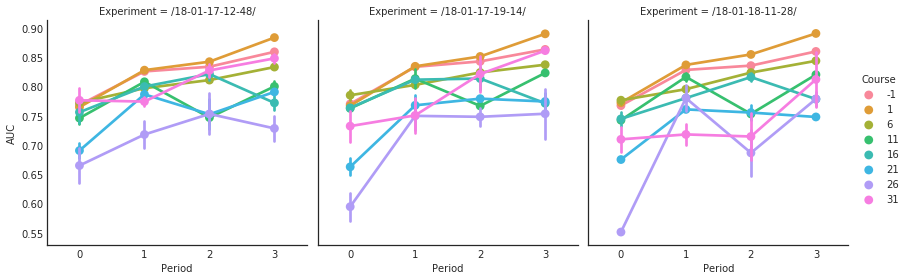

In [141]:
seaborn.factorplot(x='Period', y='AUC', hue='Course', col="Experiment", data=embedded_metrics)

### Performance on all courses, aggregated by period

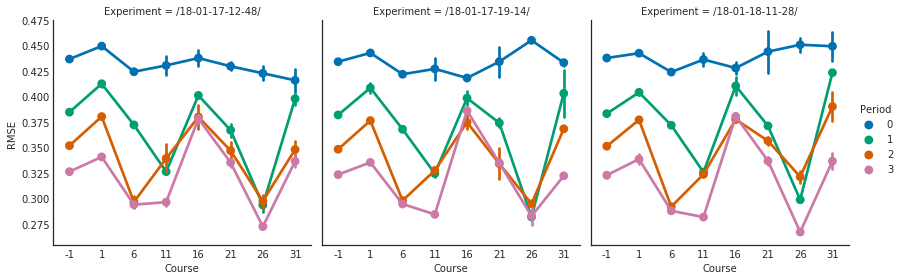

In [142]:
seaborn.factorplot(x='Course', y='RMSE', hue='Period', col="Experiment", data=embedded_metrics)

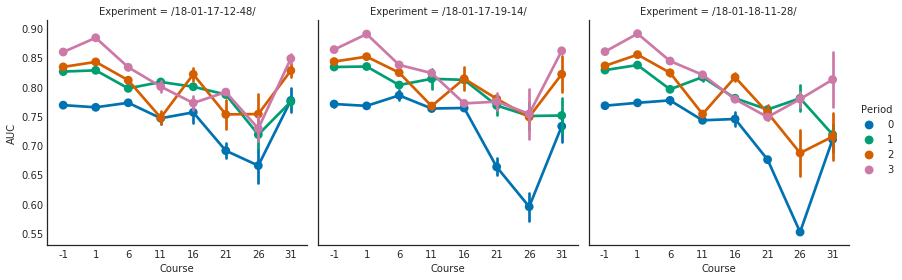

In [143]:
seaborn.factorplot(x='Course', y='AUC', hue='Period', col="Experiment", data=embedded_metrics)

# Experiments with co-embeddings

In [112]:
COEMBEDDED_EXPERIMENTS_DIRS = [
    '/home/mteruel/edm/results/kdd_early_dropout/coembedded/predictions/18-01-17-15-52/',
    '/home/mteruel/edm/results/kdd_early_dropout/coembedded/predictions/18-01-17-17-26/',
    '/home/mteruel/edm/results/kdd_early_dropout/coembedded/predictions/18-01-18-08-46/',
]

In [113]:
coembedded_metrics = read_metrics(COEMBEDDED_EXPERIMENTS_DIRS)

In [114]:
coembedded_metrics[coembedded_metrics.Course == -1].groupby(
    ['Experiment', 'Period']).mean()[['AUC', 'RMSE']]

AUC      RMSE
Experiment       Period                    
/18-01-17-15-52/ 0       0.775747  0.431070
                 1       0.826853  0.386401
                 2       0.835191  0.349720
                 3       0.856909  0.326818
/18-01-17-17-26/ 0       0.779280  0.428474
                 1       0.828635  0.383662
                 2       0.849029  0.345477
                 3       0.862858  0.328534
/18-01-18-08-46/ 0       0.768941  0.438471
                 1       0.828033  0.383476
                 2       0.841412  0.348647
                 3       0.858988  0.325885

In [115]:
coembedded_metrics.groupby(['Experiment', 'Course']).mean()[METRICS_COLS]

AUC      RMSE  Accuracy        R2
Experiment       Course                                        
/18-01-17-15-52/ -1      0.823675  0.373502  0.805729  0.310076
                  1      0.830083  0.395951  0.776020  0.330001
                  6      0.800301  0.348394  0.833739  0.268425
                  11     0.777075  0.344910  0.838648  0.206594
                  16     0.784950  0.395217  0.781743  0.215381
                  21     0.751206  0.366734  0.818842  0.112316
                  26     0.750977  0.313897  0.866094  0.120025
                  31     0.809076  0.364260  0.822390  0.212008
/18-01-17-17-26/ -1      0.829950  0.371537  0.806169  0.317348
                  1      0.838143  0.393394  0.778173  0.338740
                  6      0.815350  0.345395  0.835085  0.280348
                  11     0.797654  0.339159  0.840686  0.230451
                  16     0.791685  0.391296  0.786933  0.230523
                  21     0.777832  0.364152  0.813702  0.130234
                  26     0.730609  0.325770  0.856804  0.059376
                  31     0.806364  0.371193  0.811781  0.177024
/18-01-18-08-46/ -1      0.824343  0.374120  0.805941  0.307807
                  1      0.840398  0.390714  0.781717  0.346906
                  6      0.815874  0.346442  0.834100  0.277417
                  11     0.791675  0.341422  0.842645  0.223980
                  16     0.779032  0.400328  0.781096  0.193447
                  21     0.726574  0.380414  0.806991  0.049913
                  26     0.722623  0.329533  0.858107  0.036265
                  31     0.778699  0.388474  0.793674  0.098614

### Overfitting analysis

In [116]:
coembedded_performances = read_performances(COEMBEDDED_EXPERIMENTS_DIRS)

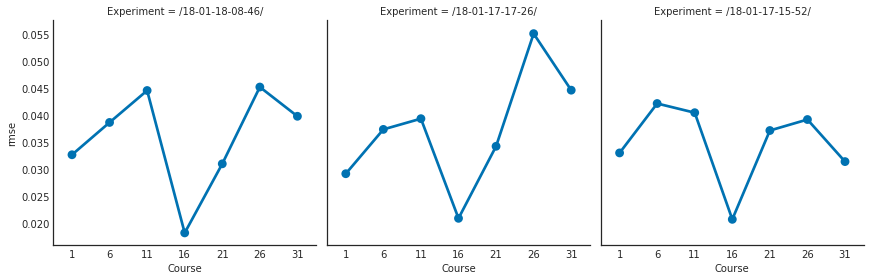

In [117]:
graphic_performances(coembedded_performances)

/home/mteruel/edm/results/kdd_early_dropout/coembedded/predictions/18-01-18-08-46/


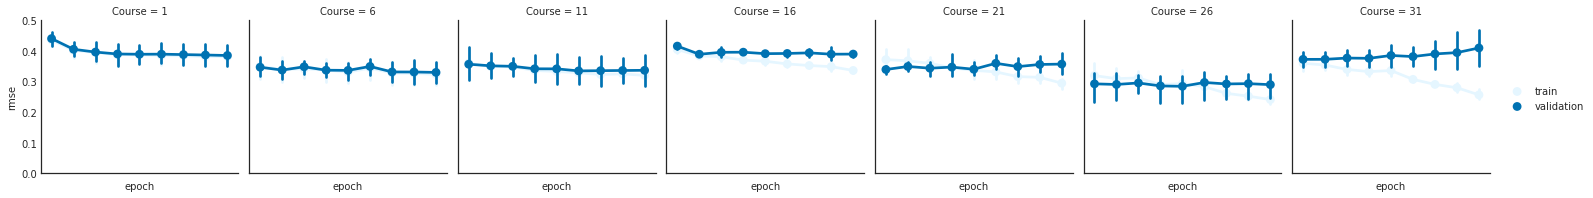

/home/mteruel/edm/results/kdd_early_dropout/coembedded/predictions/18-01-17-17-26/


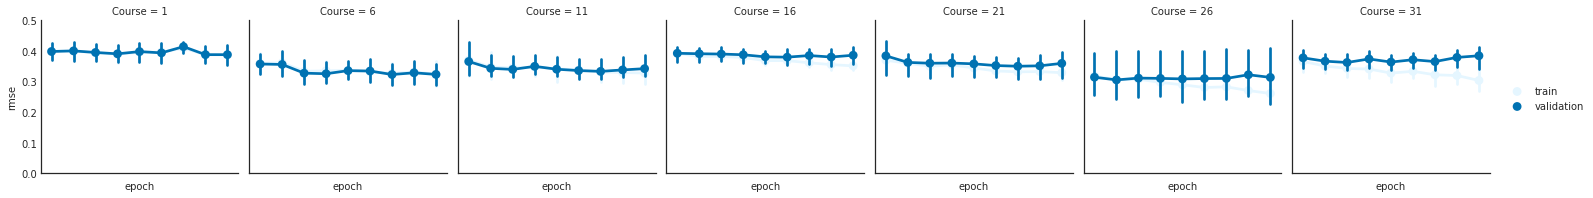

/home/mteruel/edm/results/kdd_early_dropout/coembedded/predictions/18-01-17-15-52/


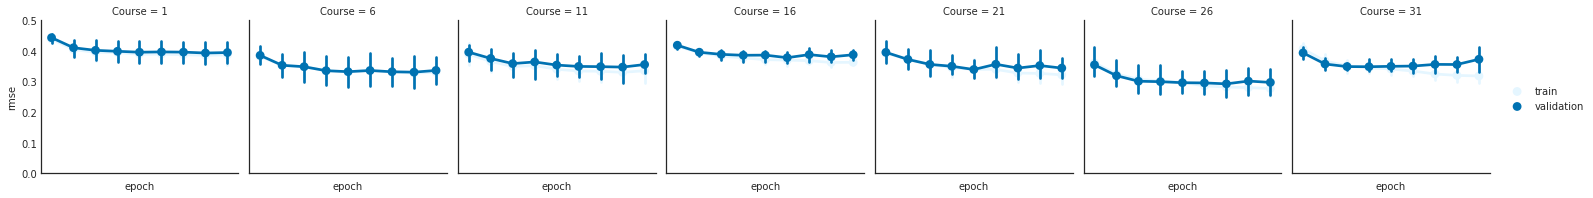

In [118]:
graphic_learning_curves(coembedded_performances)

### Performance on all periods, aggregated by course

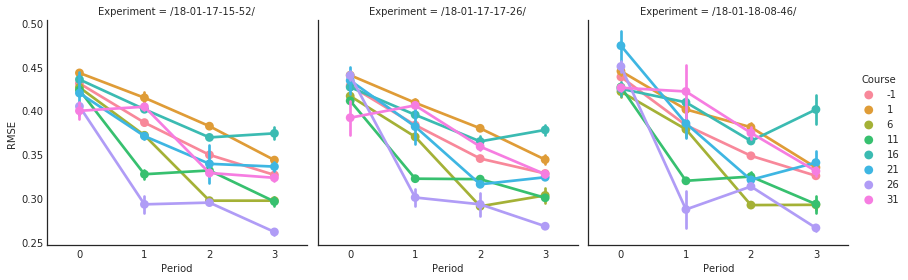

In [119]:
seaborn.factorplot(x='Period', y='RMSE', hue='Course', col="Experiment", data=coembedded_metrics)

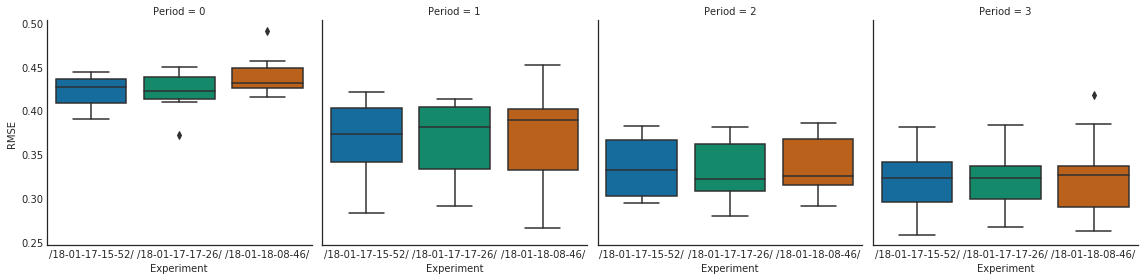

In [129]:
seaborn.factorplot(x='Experiment', y='RMSE', col="Period",
                   data=coembedded_metrics[coembedded_metrics.Course > 0], kind='box')

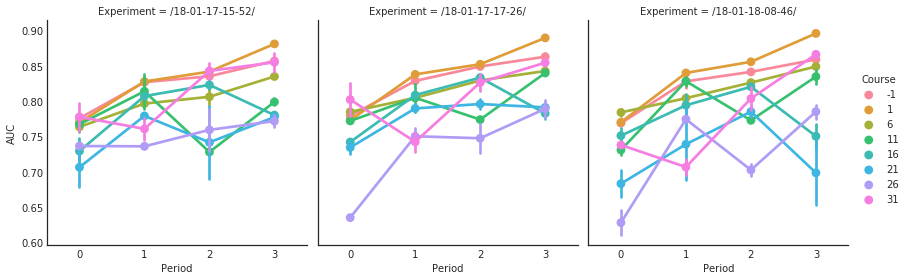

In [121]:
seaborn.factorplot(x='Period', y='AUC', hue='Course', col="Experiment", data=coembedded_metrics)

### Performance on all courses, aggregated by period

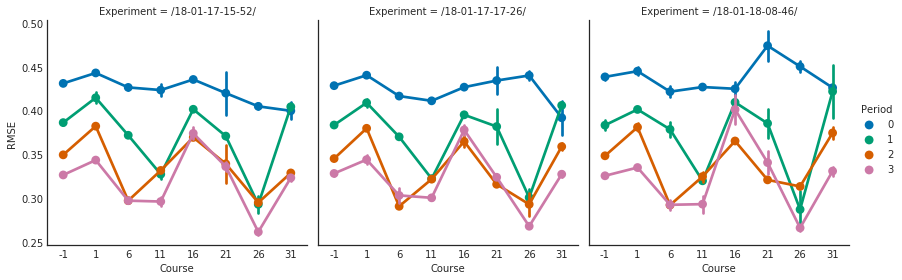

In [122]:
seaborn.factorplot(x='Course', y='RMSE', hue='Period', col="Experiment", data=coembedded_metrics)

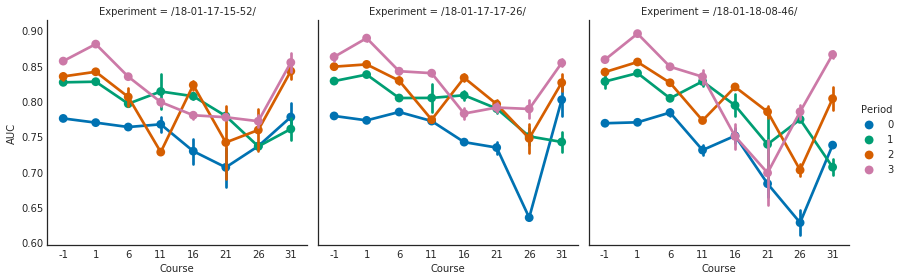

In [123]:
seaborn.factorplot(x='Course', y='AUC', hue='Period', col="Experiment", data=coembedded_metrics)